## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
### First, compute the camera calibration using chessboard images

In [204]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt
%matplotlib inline 

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

In [205]:
vidcap = cv2.VideoCapture('./project_video.mp4')
success,image = vidcap.read()
count = 0
while success:
  cv2.imwrite("./video_images/frame%d.jpg" % count, image)     # save frame as JPEG file      
  success,image = vidcap.read()
  #print('Read a new frame: ', success)
  count += 1

In [206]:
vidcap = cv2.VideoCapture('./output_images/project_video_result.mp4')
success,image = vidcap.read()
count = 0
while success:
  cv2.imwrite("./video_images_result/frame%d.jpg" % count, image)     # save frame as JPEG file      
  success,image = vidcap.read()
  #print('Read a new frame: ', success)
  count += 1

In [207]:
# Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
# Apply a distortion correction to raw images.

def calibration():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    nx, ny = 9, 6
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x,y coordinates

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('./camera_cal/*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            #cv2.imshow('img',img)
        # calibrate
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)
    return ret, mtx, dist, rvecs, tvecs
            #plt.imshow(dst)
        
def cal_undistort(img, mtx, dist):
    # Use cv2.calibrateCamera() and cv2.undistort()
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [208]:
# Color transforms, gradients, etc., to create a thresholded binary image
class find_lane():
    def __init__(self):
        self.width = 1280
        self.height = 720
    def find_lane_pipeline(self, img):
        grad_binary = self.gradient_thresh(img)
        hls_binary = self.hls_select(img, hls_thresh=(150,255))
        
        combined_binary = np.zeros_like(grad_binary)
        combined_binary[(grad_binary == 1) | (hls_binary == 1)] = 1
        return combined_binary
    
    
    def hls_select(self, img, hls_thresh):
        
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        H = hls[:,:,0]
        L = hls[:,:,1]
        S = hls[:,:,2]
        s_channel = np.zeros_like(S)
        s_channel[(S>hls_thresh[0]) & (S<=hls_thresh[1])] = 1
        return s_channel
        
        
    def gradient_thresh(self, image, sobel_kernel_mag=9, sobel_kernel_dir=15, abs_thresh=(20,100),
                           mag_thresh=(30, 100),dir_thresh=(0.7, 1.3)):
        # Apply each of the thresholding functions
        gradx = self.abs_sobel_thresh(img, abs_thresh, orient='x')
        grady = self.abs_sobel_thresh(img, abs_thresh, orient='y')
        mag_binary = self.mag_threshold(img, sobel_kernel_mag, mag_thresh)
        dir_binary = self.dir_threshold(img, sobel_kernel_dir, dir_thresh)
        combined = np.zeros_like(dir_binary)
        combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1 #((gradx == 1) & (grady == 1)) & 
        return combined

    def mag_threshold(self, img, sobel_kernel, mag_thresh):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        L = hls[:,:,1]
        #2.Gradient
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

        #3. Magnitude
        mag_sobelx = np.sqrt(sobelx**2)
        mag_sobely = np.sqrt(sobely**2)
        mag_sobel = np.sqrt(mag_sobelx**2 + mag_sobely**2)

        #4. Scale to 8-bit (0 - 255) and convert to type = np.uint8
        scale_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
        # 5) Create a binary mask where mag thresholds are met
        mag_binary = np.zeros_like(scale_sobel)
        mag_binary[(scale_sobel>=mag_thresh[0]) & (scale_sobel<=mag_thresh[1])] = 1
        return mag_binary

    def dir_threshold(self, img, sobel_kernel, dir_thresh):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        L = hls[:,:,1]
        #2.Gradient
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # 3) Take the absolute value of the x and y gradients
        abs_sobelx = np.absolute(sobelx)
        abs_sobely = np.absolute(sobely)
        # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
        dir_grad = np.arctan2(abs_sobely, abs_sobelx)
        # 5) Create a binary mask where direction thresholds are met
        dir_binary = np.zeros_like(dir_grad)
        dir_binary[(dir_grad>=dir_thresh[0]) & (dir_grad<=dir_thresh[1])] = 1
        # 6) Return this mask as your binary_output image
        #binary_output = np.copy(img) # Remove this line
        return dir_binary
 
    def abs_sobel_thresh(self, img, abs_thresh, orient):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        L = hls[:,:,1]
        if orient == 'x':
            sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
        elif orient == 'y':
            sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
        abs_sobel = np.absolute(sobel)
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        grad_binary = np.zeros_like(scaled_sobel)
        grad_binary[(scaled_sobel>=abs_thresh[0]) & (scaled_sobel<=abs_thresh[1])] = 1
        return grad_binary 
    
    def warp_perspective(self, img):
        sizex = img.shape[0] # 720
        sizey = img.shape[1] # 1280
        h, w = img.shape[:2]

        src = np.float32([[w, h-10],    # br
                          [50, h-10],    # bl
                          [550, 460],   # tl
                          [760, 460]])  # tr
        dst = np.float32([[w, h],       # br
                          [0, h],       # bl
                          [0, 0],       # tl
                          [w, 0]])      # tr
#         src = np.float32([[588,470], [245,719], [1142, 719],[734,470]])
#         dst = np.float32([[320,0], [320,720], [960, 720],[960,0]])
        M = cv2.getPerspectiveTransform(src, dst)
        Minv = cv2.getPerspectiveTransform(dst, src)
        warped = cv2.warpPerspective(img, M, (sizey, sizex), flags=cv2.INTER_LINEAR)
        # Compute the inverse perspective transform:
        return warped, Minv
    
    def find_lane_pixels(self, binary_warped):
        # HYPERPARAMETERS
        # Choose the number of sliding windows
        nwindows = 9
        #windows height
        window_height = np.int(binary_warped.shape[0]//nwindows)
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        #
        width, height = self.width, self.height
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,55,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,55,0), 2) 
            
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &\
                              (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &\
                               (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        
        return leftx, lefty, rightx, righty, out_img, left_lane_inds, right_lane_inds


    
    def fit_poly(self, binary_warped):
        # Find our lane pixels first
        leftx, lefty, rightx, righty, out_img, left_lane_inds, right_lane_inds = self.find_lane_pixels(binary_warped)

        ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        try:
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            left_fitx = 1*ploty**2 + 1*ploty
            right_fitx = 1*ploty**2 + 1*ploty

        ## Visualization ##
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [50, 0, 0]
        out_img[righty, rightx] = [0, 0, 50]

        # Plots the left and right polynomials on the lane lines
        #plt.plot(left_fitx, ploty, color='yellow')
        #plt.plot(right_fitx, ploty, color='yellow')

        return out_img, left_fit, right_fit, ploty
    
    def search_around_poly(self, binary_warped):
        # HYPERPARAMETER
        # Choose the width of the margin around the previous polynomial to search
        # The quiz grader expects 100 here, but feel free to tune on your own!
        margin = 100

        # Grab activated pixels
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Get left_fit, right_fit
        leftx, lefty, rightx, righty, out_img, left_lane_inds, right_lane_inds = self.find_lane_pixels(binary_warped)
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        ### TO-DO: Set the area of search based on activated x-values ###
        ### within the +/- margin of our polynomial function ###
        ### Hint: consider the window areas for the similarly named variables ###
        ### in the previous quiz, but change the windows to our new search area ###
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                        left_fit[1]*nonzeroy + left_fit[2] + margin)))
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                        right_fit[1]*nonzeroy + right_fit[2] + margin)))

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        ## Visualization ##
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [55, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 55]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        # Colors in the left and right lane regions
        #out_img[lefty, leftx] = [50, 0, 0]
        #out_img[righty, rightx] = [0, 0, 50]
        
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        # Plot the polynomial lines onto the image
        #plt.plot(left_fitx, ploty, color='yellow')
        #plt.plot(right_fitx, ploty, color='yellow')
        ## End visualization steps ##
        return result, left_fitx, right_fitx, left_fit, right_fit, ploty
    
    
    def fit_poly_new(self, img_shape, leftx, lefty, rightx, righty):
         ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        # Generate x and y values for plotting
        ploty = np.linspace(0, img_shape[0]-1, img_shape[0])#(0, img_shape[0]-1, img_shape[0])
        ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        return left_fitx, right_fitx, left_fit, right_fit, ploty


In [209]:
# Carvature
def measure_curvature_real(left_fit_cr, right_fit_cr, ploty):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return left_curverad, right_curverad


# Calculate the radius of curvature in meters for both lane lines
#left_curverad, right_curverad = measure_curvature_real()

#print(left_curverad, 'm', right_curverad, 'm')
# Should see values of 533.75 and 648.16 here, if using
# the default `generate_data` function with given seed number

In [210]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  

In [211]:
#1. Calibration & Distort
fl = find_lane()
ret, mtx, dist, rvecs, tvecs = calibration()
    
def img_pipeline(img):
    undist = cal_undistort(img, mtx, dist)
    
    #2. Gradient
    #test0 = fl.hls_select(img, hls_thresh=(150,255))
    #test1= fl.gradient_thresh(img)
    #test2= fl.mag_threshold(img, sobel_kernel=9, mag_thresh=(30, 100))
    #test3= fl.dir_threshold(img, sobel_kernel=15, dir_thresh=(0.7, 1.3))
    combined = fl.find_lane_pipeline(undist)
    
    #3. Perspective transform (warped)
    binary_warped, Minv = fl.warp_perspective(combined)
    
    # Histogram Find Lane
#     leftx, lefty, rightx, righty, out_img1 = fl.find_lane_pixels(binary_warped)
#     out_img, left_fit, right_fit, ploty = fl.fit_poly(binary_warped)

    #4. Find lane, Skip sliding windows
    result, left_fitx, right_fitx, left_fit, right_fit, ploty = fl.search_around_poly(binary_warped)
    
    #5. Carvature
    left_curverad, right_curverad = measure_curvature_real(left_fit, right_fit, ploty)####
    mean_curverad = int((left_curverad + right_curverad)/2)
    
    # Calculate center of the road to the center of the image
    offset_x = (1280/2) - (np.mean(left_fit) + np.mean(right_fit))/2
    #print(offset_x)
    offset_direction = "right" if offset_x > 0 else "left"
    offset_x_meter = offset_x * 3.7/700
    
    
    ############## Drawing
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    #left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    #right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    # write radius and offset onto image
    result = cv2.putText(
        result, 'Radius of Curvature = %.0f (m)' % (mean_curverad), 
        (50, 70), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (230, 230, 230), 3)
    result = cv2.putText(
        result, 'Vehicle is %.2f m %s of center' % (abs(offset_x_meter), offset_direction), 
        (50, 140), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 3)
    
    #plt.imshow(result)
    return result

Text(0.5,1,'frame1201 Image')

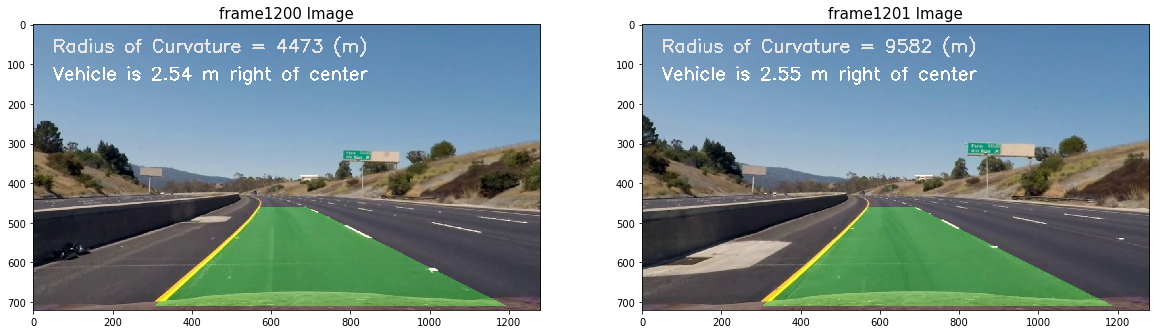

In [212]:
#1. Calibration & Distort
fl = find_lane()
ret, mtx, dist, rvecs, tvecs = calibration()

img = mpimg.imread('./video_images/frame10.jpg')#'./test_images/test2.jpg')
test2 = img_pipeline(img)

img = mpimg.imread('./video_images/frame20.jpg')
test4 = img_pipeline(img)

# visualize and save undistorted image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(test2)
ax1.set_title('frame1200 Image', fontsize=15)
ax2.imshow(test4)
ax2.set_title('frame1201 Image', fontsize=15)

Text(0.5,1,'frame1201 Image')

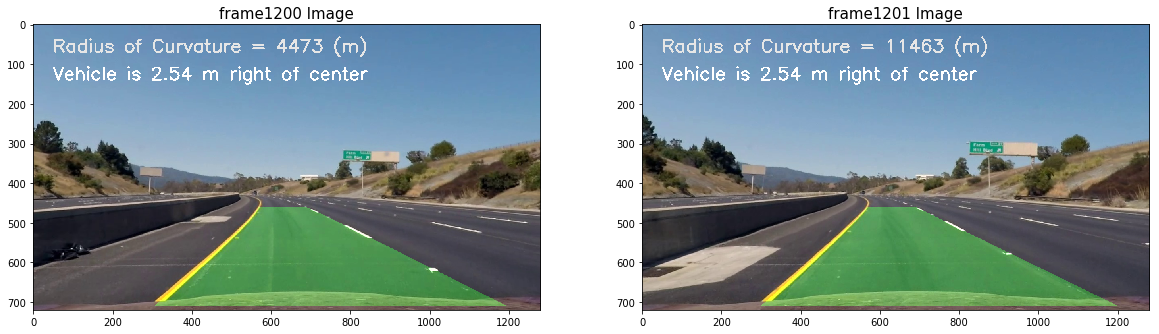

In [213]:
#1. Calibration & Distort
fl = find_lane()
ret, mtx, dist, rvecs, tvecs = calibration()

img = mpimg.imread('./video_images/frame10.jpg')#'./test_images/test2.jpg')
test2 = img_pipeline(img)

img = mpimg.imread('./video_images/frame21.jpg')
test4 = img_pipeline(img)

# visualize and save undistorted image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(test2)
ax1.set_title('frame1200 Image', fontsize=15)
ax2.imshow(test4)
ax2.set_title('frame1201 Image', fontsize=15)

In [214]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

outfile = './output_images/project_video_result.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(img_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(outfile, audio=False)

[MoviePy] >>>> Building video ./output_images/project_video_result.mp4
[MoviePy] Writing video ./output_images/project_video_result.mp4


100%|█████████▉| 1260/1261 [09:59<00:00,  2.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/project_video_result.mp4 

CPU times: user 7min 4s, sys: 46.1 s, total: 7min 50s
Wall time: 10min 2s


# Visualizing pipeline steps

In [215]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt
%matplotlib inline 

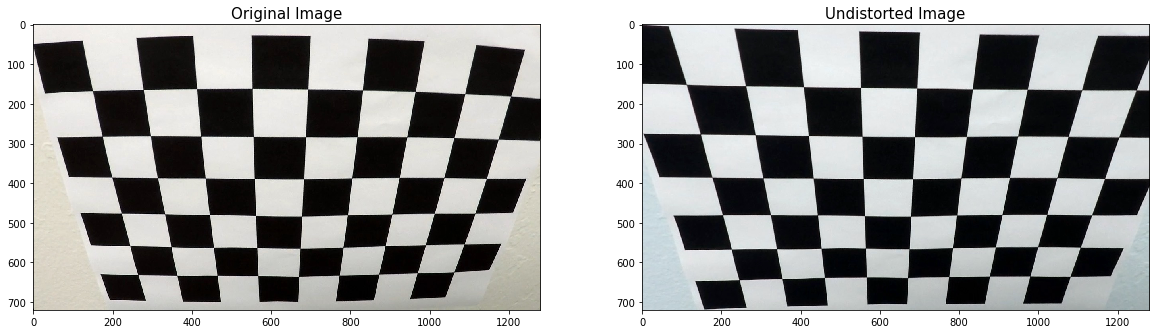

In [242]:
# Calibration & undistorted
img = cv2.imread('./camera_cal/calibration2.jpg')
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ret, mtx, dist, rvecs, tvecs = calibration()
undist = cal_undistort(img, mtx, dist)

# visualize and save undistorted image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(rgb)
ax1.set_title('Original Image', fontsize=15)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=15)
plt.imsave('./output_images/chessboard_original.jpg', rgb)
plt.imsave('./output_images/chessboard_undistort.jpg', undist)

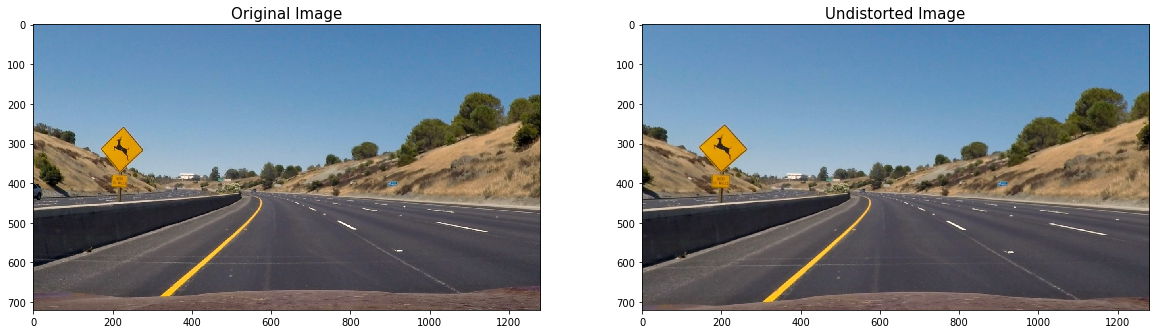

In [244]:
#ret, mtx, dist, rvecs, tvecs = calibration()
#undist = cal_undistort(img, mtx, dist)

#image = cv2.imread('./video_images/frame590.jpg')#'./test_images/test4.jpg')
image = cv2.imread('./test_images/test2.jpg')
image_RGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undistort = cal_undistort(image_RGB, mtx, dist)

# visualize and save undistorted image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(image_RGB)
ax1.set_title('Original Image', fontsize=15)
ax2.imshow(undistort)
ax2.set_title('Undistorted Image', fontsize=15)
plt.imsave('./output_images/original.jpg', image_RGB)
plt.imsave('./output_images/undistort.jpg', undistort)

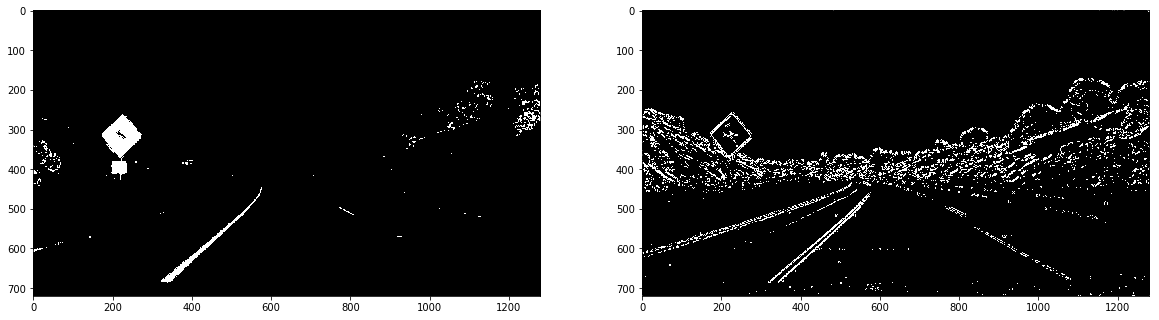

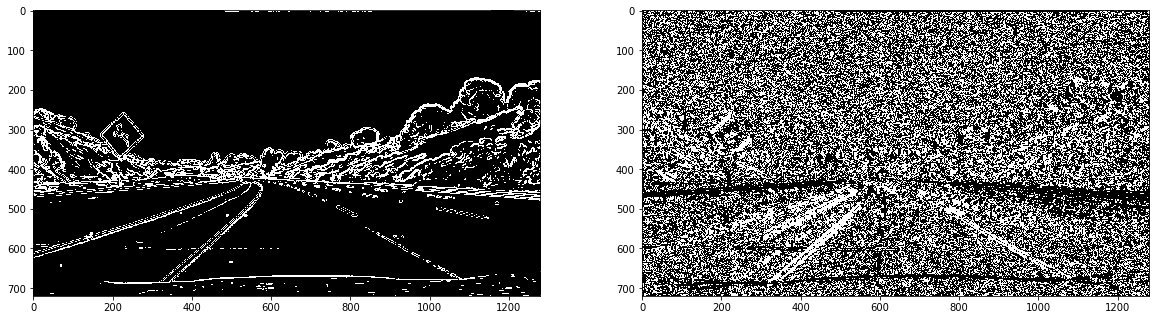

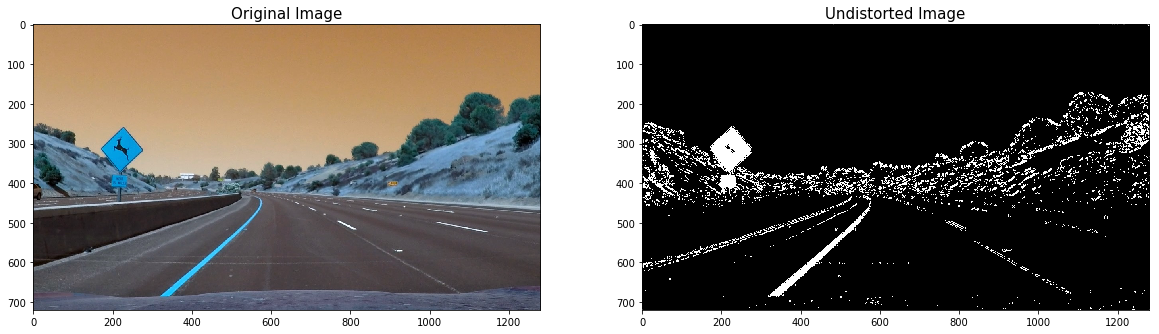

In [236]:
# Color transforms, gradients, etc., to create a thresholded binary image
fl = find_lane()
#img = mpimg.imread('./video_images/frame590.jpg')#'./test_images/test2.jpg')
img = cv2.imread('./test_images/test2.jpg')
test0 = fl.hls_select(img, hls_thresh=(150,255))
test1= fl.gradient_thresh(img)
test2= fl.mag_threshold(img, sobel_kernel=9, mag_thresh=(30, 100))
test3= fl.dir_threshold(img, sobel_kernel=15, dir_thresh=(0.7, 1.3))
combined = fl.find_lane_pipeline(img)

f, (ax3, ax4) = plt.subplots(1, 2, figsize=(20, 10))
ax3.imshow(test0, cmap='gray')
ax4.imshow(test1, cmap='gray')

f, (ax5, ax6) = plt.subplots(1, 2, figsize=(20, 10))
ax5.imshow(test2, cmap='gray')
ax6.imshow(test3, cmap='gray')

#plt.imshow(test2, cmap='gray') #cmap='gray'

#plt.imshow(combined, cmap='gray')
# visualize and save undistorted image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(img, cmap='gray')
ax1.set_title('Original Image', fontsize=15)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Undistorted Image', fontsize=15)
plt.imsave('./output_images/binary_image1.jpg', test0)
plt.imsave('./output_images/binary_image2.jpg', test1)
plt.imsave('./output_images/binary_image3.jpg', test2)
plt.imsave('./output_images/binary_image4.jpg', test3)
plt.imsave('./output_images/binary_image5.jpg', img)
plt.imsave('./output_images/binary_image6.jpg', combined)


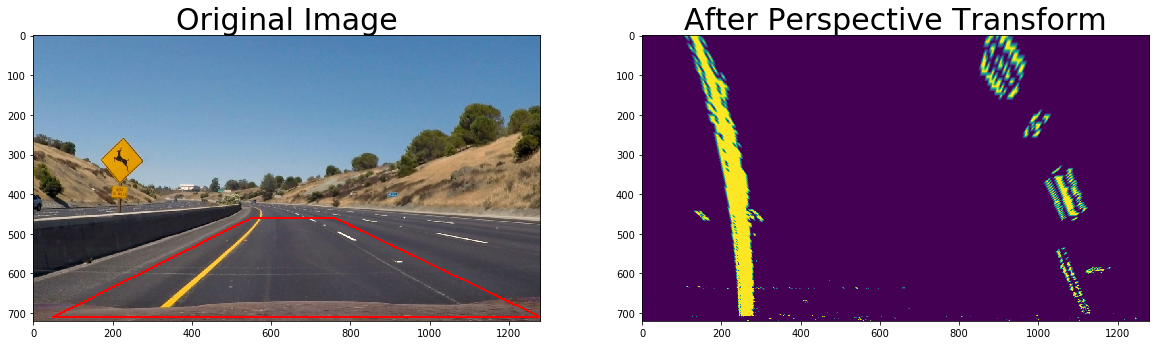

In [246]:
# Apply a perspective transform to rectify binary image ("birds-eye view").
#np.set_printoptions(threshold=10000)
h, w = img.shape[:2]

src = np.float32([[w, h-10],    # br
                  [50, h-10],    # bl
                  [550, 460],   # tl
                  [760, 460]])  # tr
dst = np.float32([[w, h],       # br
                  [0, h],       # bl
                  [0, 0],       # tl
                  [w, 0]])      # tr

binary_warped, Minv = fl.warp_perspective(combined)
#print(warped)
#plt.imshow(binary_warped) #, cmap='gray')

pts1 = np.array(src, np.int32)
pts1 = pts1.reshape((-1,1,2))
cv2.polylines(image_RGB,[pts1],True,(255,0,0),3)

# Visualize perspective transform
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image_RGB)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(binary_warped)
ax2.set_title('After Perspective Transform', fontsize=30)


plt.imsave('./output_images/before_Perspective.jpg', image_RGB)
plt.imsave('./output_images/after_Perspective.jpg', binary_warped)

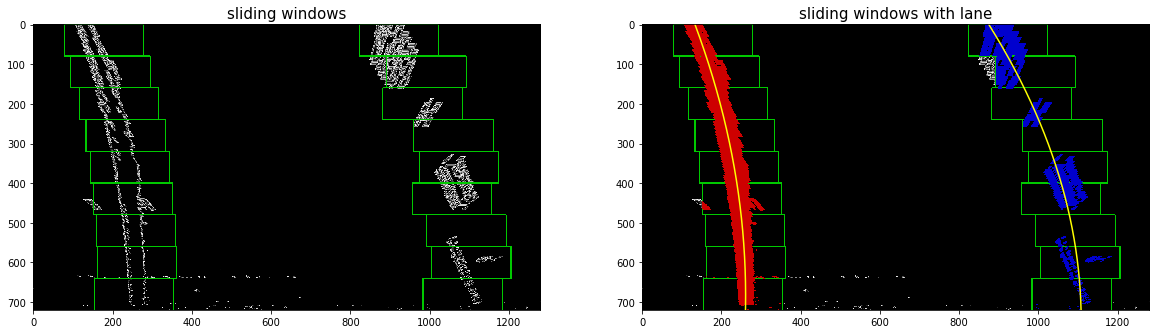

In [247]:
# Histogram
leftx, lefty, rightx, righty, out_img1, left_lane_inds, right_lane_inds = fl.find_lane_pixels(binary_warped)
#plt.imshow(out_img1)
out_img, left_fit, right_fit, ploty = fl.fit_poly(binary_warped)
#out_img[lefty, leftx] = [55, 0, 0]
#out_img[righty, rightx] = [0, 0, 255]
#plt.imshow(out_img)
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(out_img1)
ax1.set_title('sliding windows', fontsize=15)
ax2.imshow(out_img)
ax2.set_title('sliding windows with lane', fontsize=15)
ax2.plot(left_fitx, ploty, color='yellow')
ax2.plot(right_fitx, ploty, color='yellow')

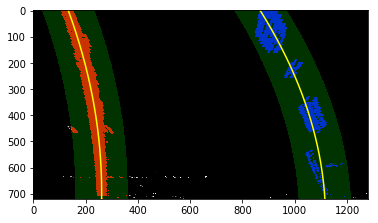

In [239]:
result, left_fitx, right_fitx, left_fit, right_fit, ploty  = fl.search_around_poly(binary_warped)

#print("warped:",out_img)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')


In [240]:
left_curverad, right_curverad = measure_curvature_real(left_fit, right_fit, ploty)
mean_curverad = int((left_curverad + right_curverad)/2)
print(mean_curverad)

2141


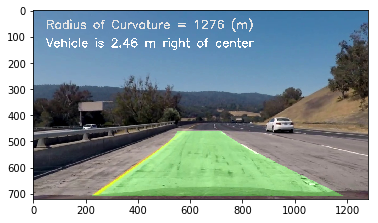

In [241]:
img = mpimg.imread('./video_images/frame591.jpg')#./test_images/test2.jpg')
image = cv2.imread('./test_images/test4.jpg')
result = img_pipeline(img)

plt.imshow(result)